In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import hockey_rink
import hockey_scraper
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

Noe have shift data for the nhl 2023-24 season as well as the play by play data (pbp) in separate csv files. 

In [2]:
#Loading in pbp data
pbp=pd.read_csv("nhl_pbp_20232024.csv")

In [3]:
# Drop rows where xC or yC is NaN
pbp = pbp.dropna(subset=['xC', 'yC'])
pbp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 323164 entries, 1 to 445636
Data columns (total 57 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       323164 non-null  int64  
 1   Game_Id          323164 non-null  int64  
 2   Date             323164 non-null  object 
 3   Period           323164 non-null  int64  
 4   Event            323164 non-null  object 
 5   Description      323164 non-null  object 
 6   Time_Elapsed     323164 non-null  object 
 7   Seconds_Elapsed  323164 non-null  float64
 8   Strength         323164 non-null  object 
 9   Ev_Zone          270144 non-null  object 
 10  Type             139605 non-null  object 
 11  Ev_Team          270069 non-null  object 
 12  Home_Zone        270144 non-null  object 
 13  Away_Team        323164 non-null  object 
 14  Home_Team        323164 non-null  object 
 15  p1_name          270001 non-null  object 
 16  p1_ID            263648 non-null  float64
 

Step 2: Data Cleansing

Definitely do not need many of these variables so going to drop a bunch of them

Alright looks like players 1,2, and 3 are the forwards. 4 and 5 are the defensemen and 6 is the goalie, So i only need players 1-3

In [4]:
pbp=pbp.drop(['Away_Coach','Home_Coach','Home_Goalie_Id','Home_Goalie','Away_Goalie_Id','Away_Goalie', 'Unnamed: 0','awayPlayer4','awayPlayer4_id','awayPlayer5','awayPlayer5_id','awayPlayer6','awayPlayer6_id','homePlayer4','homePlayer4_id','homePlayer5','homePlayer5_id','homePlayer6','homePlayer6_id'], axis=1)

In [5]:
pbp.Type.value_counts()

Type
WRIST SHOT                              77163
SNAP SHOT                               18419
SLAP SHOT                               16066
TIP-IN                                   9190
BACKHAND                                 8148
                                        ...  
AR #77 DEANGELO Slashing(2 min)             1
OS #61 MAROON High-sticking(2 min)          1
AL #3 TANEV Delay Game(2 min)               1
AL #3 TANEV High-sticking(2 min)            1
YR #96 ROSLOVIC High-sticking(2 min)        1
Name: count, Length: 204, dtype: int64

Got rid of a ton of columns not needed. All columns now should be useful

In [6]:
pbp.columns

Index(['Game_Id', 'Date', 'Period', 'Event', 'Description', 'Time_Elapsed',
       'Seconds_Elapsed', 'Strength', 'Ev_Zone', 'Type', 'Ev_Team',
       'Home_Zone', 'Away_Team', 'Home_Team', 'p1_name', 'p1_ID', 'p2_name',
       'p2_ID', 'p3_name', 'p3_ID', 'awayPlayer1', 'awayPlayer1_id',
       'awayPlayer2', 'awayPlayer2_id', 'awayPlayer3', 'awayPlayer3_id',
       'homePlayer1', 'homePlayer1_id', 'homePlayer2', 'homePlayer2_id',
       'homePlayer3', 'homePlayer3_id', 'Away_Players', 'Home_Players',
       'Away_Score', 'Home_Score', 'xC', 'yC'],
      dtype='object')

Variables we want, many of which need to be modified or created:

    1)xC (modified) (Done)

    2)yC (Modified) (Done)

    3)Type (modified) (Done)

    4)shotDistance (Create)

    5)shotAngle (Create)

    6)timeSinceLastEvent (Create) (Done)

    7)distanceFromLastEvent (Create) (Have to calculate before transposing the x and y coordinates, cuz what if back to back shots happen between the two teams?) (Done)

    8)PowerPlay (Create) (Done)

    9) Goal (Create) - TARGET VARIABLE (Done)

-Date needs to be last of reg season, not last of entire season including playoffs

Calculating the distanceFromLastEvent prior to transposing x and y coordinates

In [7]:
# Calculate the difference in x and y coordinates between consecutive events
pbp['x_diff'] = pbp['xC'].diff()
pbp['y_diff'] = pbp['yC'].diff()

# Calculate the Euclidean distance between consecutive events
pbp['distanceFromLastEvent'] = np.sqrt(pbp['x_diff']**2 + pbp['y_diff']**2)

# Fill NaN values that may result from the first row
pbp['distanceFromLastEvent'] = pbp['distanceFromLastEvent'].fillna(0)

# Optionally, drop the intermediate x_diff and y_diff columns if no longer needed
pbp = pbp.drop(columns=['x_diff', 'y_diff'])

Making all shots occur on the right side of the rink, modifying the xC and yC

In [8]:
#First making all shots appear on the positive (right side of the rink)
pbp['xC']=np.where(pbp['xC']<0, pbp['xC']*-1, pbp['xC'])
pbp['yC']=np.where(pbp['xC']<0, pbp['yC']*-1, pbp['yC'])

Making new column for PowerPlay, 1 means yes there is a pp and 0 means no pp

In [9]:
# Make a new column for whether or not its a power play goal. 
pbp['Power Play'] = np.where( ((pbp.Ev_Team.equals(pbp.Home_Team)) & (pbp.Strength.str[0] > pbp.Strength.str[2])) | ((pbp.Ev_Team.equals(pbp.Away_Team)) & (pbp.Strength.str[0] < pbp.Strength.str[2])), 1, 0)

Getting time since last event (Right now have seconds elapsed, which is just time elapsed from period. So to get time elapsed since last event, Just have to subtract seconds elased on previous row/event from the current row/event)

In [10]:
pbp['timeSinceLastEvent']= pbp['Seconds_Elapsed'].diff()
pbp['timeSinceLastEvent'] = pbp['timeSinceLastEvent'].fillna(0)


Make the each shot type into individual binary value columns using one hot encoding (Then keeping the columns created that represents shots only: WRIST SHOT,SNAP SHOT,SLAP SHOT,TIP-IN,BACKHAND, Done at the very end of data cleaning)

In [11]:
pbp['Type'].value_counts()

Type
WRIST SHOT                              77163
SNAP SHOT                               18419
SLAP SHOT                               16066
TIP-IN                                   9190
BACKHAND                                 8148
                                        ...  
AR #77 DEANGELO Slashing(2 min)             1
OS #61 MAROON High-sticking(2 min)          1
AL #3 TANEV Delay Game(2 min)               1
AL #3 TANEV High-sticking(2 min)            1
YR #96 ROSLOVIC High-sticking(2 min)        1
Name: count, Length: 204, dtype: int64

Im going to keep only the values of type above not any other crazy ones. I am also going to convert to string.

In [12]:
pbp['Type'] = pbp['Type'].astype(str)
pbp=pbp[(pbp['Type']=='WRIST SHOT') | (pbp['Type']=='SNAP SHOT') | (pbp['Type']=='SLAP SHOT') | (pbp['Type']=='TIP-IN') | (pbp['Type']=='BACKHAND') | (pbp['Type']=='DEFLECTED') | (pbp['Type']=='WRAP-AROUND') ]

In [13]:
#checking 
pbp['Type'].value_counts()

Type
WRIST SHOT     77163
SNAP SHOT      18419
SLAP SHOT      16066
TIP-IN          9190
BACKHAND        8148
DEFLECTED       2074
WRAP-AROUND      919
Name: count, dtype: int64

In [14]:
# Ensure the Type column is clean (e.g., no leading/trailing spaces)
pbp['Type'] = pbp['Type'].str.strip()

# Identify unique categories
unique_types = pbp['Type'].unique()

# Manually one-hot encode
for shot_type in unique_types:
    pbp[shot_type] = (pbp['Type'] == shot_type).astype(int)

In [15]:
#Checking columns
pbp.columns

Index(['Game_Id', 'Date', 'Period', 'Event', 'Description', 'Time_Elapsed',
       'Seconds_Elapsed', 'Strength', 'Ev_Zone', 'Type', 'Ev_Team',
       'Home_Zone', 'Away_Team', 'Home_Team', 'p1_name', 'p1_ID', 'p2_name',
       'p2_ID', 'p3_name', 'p3_ID', 'awayPlayer1', 'awayPlayer1_id',
       'awayPlayer2', 'awayPlayer2_id', 'awayPlayer3', 'awayPlayer3_id',
       'homePlayer1', 'homePlayer1_id', 'homePlayer2', 'homePlayer2_id',
       'homePlayer3', 'homePlayer3_id', 'Away_Players', 'Home_Players',
       'Away_Score', 'Home_Score', 'xC', 'yC', 'distanceFromLastEvent',
       'Power Play', 'timeSinceLastEvent', 'WRIST SHOT', 'TIP-IN', 'SNAP SHOT',
       'SLAP SHOT', 'BACKHAND', 'DEFLECTED', 'WRAP-AROUND'],
      dtype='object')

Dropping shots from behind the net

In [16]:
pbp.drop(pbp[pbp['xC'] > 89].index, inplace=True)

Getting goals column

In [17]:
# Add a binary column for Goals 
pbp['goal'] = np.where(pbp.Event == 'GOAL', 1, 0)

In [18]:
pbp['goal'].value_counts()

goal
0    114067
1      6846
Name: count, dtype: int64

In [19]:
pbp['Event'].value_counts()

Event
SHOT     59390
BLOCK    30792
MISS     23885
GOAL      6846
Name: count, dtype: int64

We can drop all rows where event is not equal to shot or goal because we already calculated the distance from last event and the time since last event which were the variables that needed to have every event in the dataframe. 

In [20]:
pbp=pbp[(pbp['Event']=='SHOT') | (pbp['Event']=='GOAL') | (pbp['Event']=='MISS')]

Ok, lets get a sense on where out dataframe is at, how many rows contain na values for the x and y coordinates?

In [21]:
# Count the number of NaN values in the xC and yC columns
xC_nan_count = pbp['xC'].isna().sum()
yC_nan_count = pbp['yC'].isna().sum()

# Print the counts
print(f"Number of NaN values in xC: {xC_nan_count}")
print(f"Number of NaN values in yC: {yC_nan_count}")

Number of NaN values in xC: 0
Number of NaN values in yC: 0


How many total values are in our dataframe?

In [22]:
pbp.shape

(90121, 49)

Getting shot angles using a function

In [23]:
# This function calculates the angle to the center of the net at (89, 0) in radians and degrees.
def angles(x, y):
    num = math.sqrt(((89.0 - x) * (89.0 - x)) + ((y) * (y)))
    if num==0:
        radians= 0.0
        degrees= 0.0
    else:
        radians = np.arcsin(y/num)
        degrees = (radians * 180.0) / 3.14
        
    arr = [radians, degrees]
    return arr

Now using that function to place angles into dataframe and also get shot distance

In [24]:
# Initiliaze empty columns
pbp['shotAngle_Radians'] = ''
pbp['shotAngle_Degrees'] = ''
pbp['shotDistance'] = ''

# Add values to columns 
for index, row in pbp.iterrows():
    x = row['xC']
    y = row['yC']
    all_angles = angles(x, y)
    pbp.at[index, 'shotAngle_Radians'] = all_angles[0]
    pbp.at[index, 'shotAngle_Degrees'] = all_angles[1]
    pbp.at[index, 'shotDistance'] = np.sqrt((y - 0)**2 + (x - 89.0)**2)

Last step is to limit games to only regular season games. Last day of the regular season was 04-18. Get rid of all rows with a date after that. 

In [25]:
dtype = pbp['Date'].dtype
print(dtype)

object


In [26]:
pbp['Date'].tail()

445623    2024-06-24
445626    2024-06-24
445627    2024-06-24
445628    2024-06-24
445634    2024-06-24
Name: Date, dtype: object

Alright to accomplish getting rid of playoff data, have to convert the date column to datetime format, and then filter for rows before 2024-04-18

In [27]:
# Convert 'date' column to datetime format
pbp['Date'] = pd.to_datetime(pbp['Date'])

# Define the cutoff date
cutoff_date = pd.to_datetime('2024-04-18')

# Filter rows where the date is after the cutoff date
pbp = pbp[pbp['Date'] <= cutoff_date]

Alright now to only keep the variables we want. Dropping all other columns. Then our data should be good to go for modeling!!

Shot types:  'WRIST SHOT', 'TIP-IN', 'SNAP SHOT',
       'SLAP SHOT', 'BACKHAND', 'DEFLECTED', 'WRAP-AROUND'

In [28]:
pbp=pbp[['Ev_Zone','Ev_Team','Home_Team','Away_Team','Event', 'awayPlayer1','awayPlayer2','awayPlayer3','homePlayer1','homePlayer2','homePlayer3','Description','Strength', 'Seconds_Elapsed', 'timeSinceLastEvent','goal','distanceFromLastEvent','Power Play','xC','yC','shotAngle_Radians','shotAngle_Degrees','shotDistance','BACKHAND', 'DEFLECTED', 'SLAP SHOT', 'SNAP SHOT', 'TIP-IN', 'WRAP-AROUND', 'WRIST SHOT','Description','Type']]

Alright, now that we got rid of a good number of columns we don't need, let's think about the problem at hand. I want to evaluate who are the best 20 forward lines in the nhl. How should I accomplish this? I think the best way from a hollistic standpoint is expected goals %. Expected Goals % is the percent of all expected goals the player's team gets while the player is on the ice compared to the other team. For example, if a player's team gets 0.6 expected goals and the opposing team gets 0.4 expected goals while the player is on the ice, the player's expected goals % is 60%. 

On MoneyPuck, an xGoals% of above 60% gets a forward line inside the top 10 (Limiting to lines who played 200 minutes or more together).An xGoals% of 50% and above gets a FL inside the top 60 lines. 

I also want to look at each lines expected goals against and their expected goals for, rather than the percentage of expected goal they own. An expected goals for of 28 or above gets you in the top 10, and an xG For of 20 gets you inside the top 25. 

For xG against, 8.5 or less gets you inside the top 10, 11 or less gets you inside the top 25. 

By looking at these xG for and xG against rather than xG%, I can get the best offensive forward lines and the best defensive lines.

Thus, at the very end of this project my goal is to have 3 different rankings:
1) The best 15 lines in hockey (using xG%)
2) The best 15 offensive lines in hockey (using xG For)
3) The best 15 defensive lines in hockey (using xG Against)

Step 3: Building the model and features to be passed into the model

pbp=pbp[['Ev_Zone','Ev_Team','Home_Team','Away_Team','Event', 'awayPlayer1','awayPlayer2','awayPlayer3','homePlayer1','homePlayer2','homePlayer3','Description','Strength', 'Seconds_Elapsed', 'timeSinceLastEvent','goal','distanceFromLastEvent','Power Play','xC','yC','shotAngle_Radians','shotAngle_Degrees','shotDistance','BACKHAND', 'DEFLECTED', 'SLAP SHOT', 'SNAP SHOT', 'TIP-IN', 'WRAP-AROUND', 'WRIST SHOT','Description','Type']]

Alright, in the expected goals model I am building, these variables will be features with variable 15 being the target:
    1)xC
    2)yC
    3)BACKHAND
    4)DEFLECTED
    5)SLAP SHOT
    6)SNAP SHOT
    7)TIP-IN
    8)WRAP-AROUND
    9)WRIST SHOT
    10)shotAngle_Degrees
    11)timeSinceLastEvent
    12)shotDistance
    13)distanceFromLastEvent
    14)Power Play

    15)goal (Target variable)

Looking at the data types of our variables. All variables being passed into model need to be int/double/float. 

In [29]:
pbp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84546 entries, 6 to 413852
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Ev_Zone                84546 non-null  object 
 1   Ev_Team                84546 non-null  object 
 2   Home_Team              84546 non-null  object 
 3   Away_Team              84546 non-null  object 
 4   Event                  84546 non-null  object 
 5   awayPlayer1            84546 non-null  object 
 6   awayPlayer2            84060 non-null  object 
 7   awayPlayer3            84038 non-null  object 
 8   homePlayer1            84546 non-null  object 
 9   homePlayer2            84063 non-null  object 
 10  homePlayer3            84039 non-null  object 
 11  Description            84546 non-null  object 
 12  Strength               84546 non-null  object 
 13  Seconds_Elapsed        84546 non-null  float64
 14  timeSinceLastEvent     84546 non-null  float64
 15  goal  

Need to convert shotDistance, and both shotAngle variables to float64 instead of object

In [30]:
pbp['shotDistance'] = pd.to_numeric(pbp['shotDistance'], errors='coerce').astype('float64')
pbp['shotAngle_Degrees'] = pd.to_numeric(pbp['shotAngle_Degrees'], errors='coerce').astype('float64')
pbp['shotAngle_Radians'] = pd.to_numeric(pbp['shotAngle_Radians'], errors='coerce').astype('float64')

Checking to make sure it worked

In [31]:
pbp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84546 entries, 6 to 413852
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Ev_Zone                84546 non-null  object 
 1   Ev_Team                84546 non-null  object 
 2   Home_Team              84546 non-null  object 
 3   Away_Team              84546 non-null  object 
 4   Event                  84546 non-null  object 
 5   awayPlayer1            84546 non-null  object 
 6   awayPlayer2            84060 non-null  object 
 7   awayPlayer3            84038 non-null  object 
 8   homePlayer1            84546 non-null  object 
 9   homePlayer2            84063 non-null  object 
 10  homePlayer3            84039 non-null  object 
 11  Description            84546 non-null  object 
 12  Strength               84546 non-null  object 
 13  Seconds_Elapsed        84546 non-null  float64
 14  timeSinceLastEvent     84546 non-null  float64
 15  goal  

In [32]:
pbp.tail()

,Ev_Zone,Ev_Team,Home_Team,Away_Team,Event,awayPlayer1,awayPlayer2,awayPlayer3,homePlayer1,homePlayer2,...,shotDistance,BACKHAND,DEFLECTED,SLAP SHOT,SNAP SHOT,TIP-IN,WRAP-AROUND,WRIST SHOT,Description,Type
413826,Off,L.A,L.A,CHI,MISS,JASON DICKINSON,PHILIPP KURASHEV,CONNOR BEDARD,BLAKE LIZOTTE,TREVOR LEWIS,...,14.142136,0,0,0,0,0,0,1,"LAK #22 FIALA, Wrist, Wide Right, Off. Zone, 5...",WRIST SHOT
413835,Off,L.A,L.A,CHI,SHOT,ANDREAS ATHANASIOU,TYLER JOHNSON,LUKAS REICHEL,BLAKE LIZOTTE,TREVOR LEWIS,...,41.677332,0,0,1,0,0,0,0,"LAK ONGOAL - #84 GAVRIKOV, Slap , Off. Zone, 6...",SLAP SHOT
413838,Off,L.A,L.A,CHI,MISS,JASON DICKINSON,PHILIPP KURASHEV,CONNOR BEDARD,PHILLIP DANAULT,PIERRE-LUC DUBOIS,...,11.401754,0,0,0,0,1,0,0,"LAK #24 DANAULT, Tip-In, Wide Right, Off. Zone...",TIP-IN
413845,Off,L.A,L.A,CHI,GOAL,JASON DICKINSON,NICK FOLIGNO,SETH JONES,ANZE KOPITAR,ADRIAN KEMPE,...,56.586217,0,0,0,0,0,0,1,"LAK #33 ARVIDSSON(6), Wrist , Off. Zone, 16 ft...",WRIST SHOT
413852,Off,L.A,L.A,CHI,GOAL,PHILIPP KURASHEV,CONNOR BEDARD,KEVIN KORCHINSKI,ANZE KOPITAR,ADRIAN KEMPE,...,46.065171,0,0,0,1,0,0,0,"LAK #9 KEMPE(28), Snap , Off. Zone, 32 ft.",SNAP SHOT


First step, is splitting the feature/predictor variables from the target variable

In [33]:
X=pbp[['timeSinceLastEvent','distanceFromLastEvent','Power Play','xC','yC','shotAngle_Degrees','shotDistance','BACKHAND', 'DEFLECTED', 'SLAP SHOT', 'SNAP SHOT', 'TIP-IN', 'WRAP-AROUND', 'WRIST SHOT']]
y=pbp.goal

Splitting data into train and test data

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test= train_test_split(X,y,test_size=0.2, random_state=16)

XGBoost Start

Attempt at Grid Search

In [35]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier


In [36]:
# Define the parameter grid
param_grid = {
    'max_depth': [3, 7, 12],          # Different values for max depth of a tree
    'learning_rate': [0.01, 0.1, 0.3],  # Learning rate (eta)
    'n_estimators': [100, 500, 1000],    # Number of boosting rounds
    'subsample': [0.8, 1.0]            # Subsample ratio of the training instances
    #'scale_pos_weight': [1,7,18]
}

In [37]:
# Initialize XGBoost model
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='auc', use_label_encoder=False)

In [38]:
# Set up Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=1)

In [40]:
# Fit the model
grid_search.fit(X_train, y_train)
#Takes a long time, going to run at night

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[13:56:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[13:56:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[13:56:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[13:56:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[13:56:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "u

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 7, 12],
                         'n_estimators': [100, 500, 1000],
                         'subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=1)

In [41]:
# Get the best parameters from the grid search
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.8}


In [42]:
# Train the final model using the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

[14:18:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Alright calculating the auc score for the training data to see if there is a signifcant difference from the auc score on the test data

In [43]:
# Predict probabilities for the training set
y_train_pred_prob = best_model.predict_proba(X_train)[:, 1]  # Probabilities for the positive class

# Evaluate the AUC score
roc_auc = roc_auc_score(y_train, y_train_pred_prob)
print(f'ROC AUC: {roc_auc}')

ROC AUC: 0.6444969460647043


In [44]:
# Predict on the test data
y_pred = best_model.predict_proba(X_test)[:, 1]

In [45]:
y_pred

array([0.0629987 , 0.04032657, 0.07972875, ..., 0.07938475, 0.04909216,
       0.12149397], dtype=float32)

In [46]:
# Evaluate the model
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc}')

ROC AUC: 0.6139955285032432


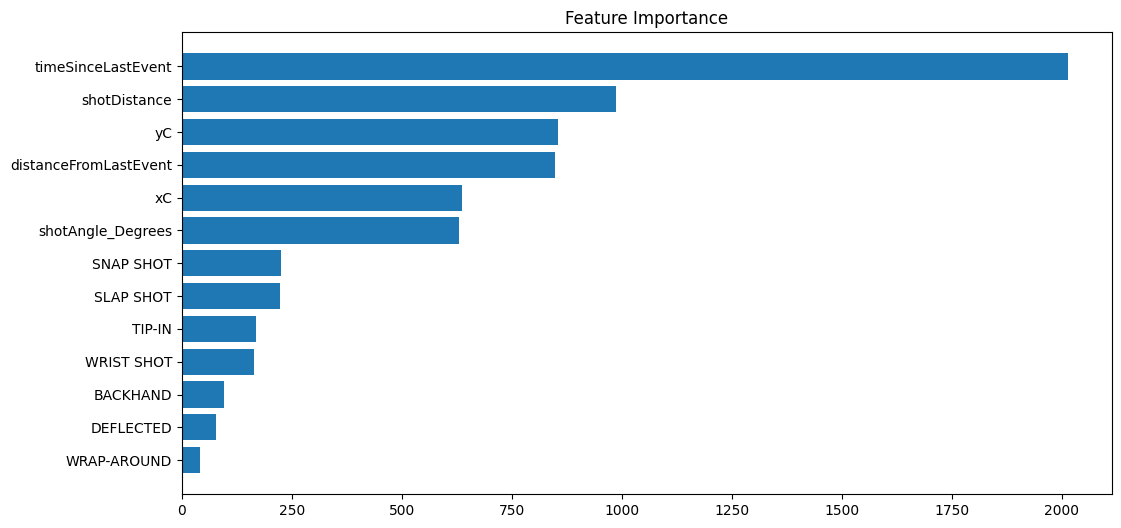

In [47]:
#Feature importance
from sklearn.inspection import permutation_importance
feature_importance = best_model.get_booster().get_score(importance_type='weight')

# Convert to array for plotting
sorted_idx = np.argsort(list(feature_importance.values()))
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), np.array(list(feature_importance.values()))[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(list(feature_importance.keys()))[sorted_idx])
plt.title('Feature Importance')
plt.show()

Once Model is built, then since we are trying to find best forward lines, Group by player1, player2, player3. Sum their expected goals. Take top 15.

In [48]:
pred_varBoost= pbp[['timeSinceLastEvent','distanceFromLastEvent','Power Play','xC','yC','shotAngle_Degrees','shotDistance','BACKHAND', 'DEFLECTED', 'SLAP SHOT', 'SNAP SHOT', 'TIP-IN', 'WRAP-AROUND', 'WRIST SHOT']]

# Predict using the best_model
xG = best_model.predict_proba(pred_varBoost)[:, 1]

# Add the predictions to your DataFrame
pbp['xG'] = xG


# dtest=xgb.DMatrix(pred_varBoost)
# xG=bst.predict(dtest)
# pbp['xG']=xG

In [49]:
pbp.head()

,Ev_Zone,Ev_Team,Home_Team,Away_Team,Event,awayPlayer1,awayPlayer2,awayPlayer3,homePlayer1,homePlayer2,...,BACKHAND,DEFLECTED,SLAP SHOT,SNAP SHOT,TIP-IN,WRAP-AROUND,WRIST SHOT,Description,Type,xG
6,Off,T.B,T.B,NSH,SHOT,COLTON SISSONS,YAKOV TRENIN,COLE SMITH,BRAYDEN POINT,STEVEN STAMKOS,...,0,0,0,0,0,0,1,"TBL ONGOAL - #43 RADDYSH, Wrist , Off. Zone, 3...",WRIST SHOT,0.098621
40,Off,T.B,T.B,NSH,SHOT,PHILIP TOMASINO,RYAN O'REILLY,LUKE EVANGELISTA,BRAYDEN POINT,STEVEN STAMKOS,...,0,0,0,0,0,0,1,"TBL ONGOAL - #77 HEDMAN, Wrist , Off. Zone, 63...",WRIST SHOT,0.064260
41,Off,T.B,T.B,NSH,GOAL,JUUSO PARSSINEN,RYAN O'REILLY,FILIP FORSBERG,BRAYDEN POINT,STEVEN STAMKOS,...,0,0,1,0,0,0,0,"TBL #86 KUCHEROV(1), Slap , Off. Zone, 42 ft.A...",SLAP SHOT,0.062019
44,Neu,T.B,T.B,NSH,MISS,JUUSO PARSSINEN,RYAN O'REILLY,FILIP FORSBERG,TYLER MOTTE,ANTHONY CIRELLI,...,0,0,0,0,0,0,1,"TBL #64 MOTTE, Wrist, Wide Right, Neu. Zone, 8...",WRIST SHOT,0.053883
47,Off,T.B,T.B,NSH,SHOT,COLTON SISSONS,YAKOV TRENIN,COLE SMITH,LUKE GLENDENING,WALTTERI MERELA,...,0,0,0,1,0,0,0,"TBL ONGOAL - #81 CERNAK, Snap , Off. Zone, 62 ...",SNAP SHOT,0.082742


Alright going to merge in nhl team logos so that I can display nicely in final dataframe once I group the forward lines. That way you can see which team the forward line belongs to. This requires me to load in the nhl logos csv, and also map the abbreviations so that I can merge onto the pbp dataframe.

In [50]:
nhl_logos=pd.read_csv("nhl_logos.csv")

Need to see the abbreviations from the pbp so I can create the mappings

In [51]:
pbp['Ev_Team'].unique()

array(['T.B', 'NSH', 'PIT', 'CHI', 'SEA', 'VGK', 'OTT', 'CAR', 'TOR',
       'MTL', 'BOS', 'WPG', 'CGY', 'COL', 'L.A', 'EDM', 'VAN', 'NYR',
       'BUF', 'CBJ', 'PHI', 'DET', 'N.J', 'DAL', 'STL', 'FLA', 'MIN',
       'S.J', 'ARI', 'WSH', 'NYI', 'ANA'], dtype=object)

In [52]:
nhl_logos['refe_abrName'].unique()

array(['CAR', 'CHI', 'CBJ', 'DAL', 'DET', 'FLA', 'NSH', 'TBL', 'BOS',
       'BUF', 'NJD', 'NYI', 'NYR', 'PHI', 'PIT', 'WSH', 'CGY', 'EDM',
       'MTL', 'OTT', 'TOR', 'VAN', 'WPG', 'ANA', 'ARI', 'COL', 'LAK',
       'MIN', 'SJS', 'STL', 'VEG', 'SEA'], dtype=object)

In [53]:
nhl_logos=nhl_logos[['refe_abrName','espn_logo']]

In [54]:
#Mapping dictionary
abbrev_map = {
    'T.B': 'TBL',   
    'NSH': 'NSH',
    'PIT': 'PIT',
    'CHI': 'CHI',  # Example: Golden Knights
    'SEA': 'SEA',
    'VGK': 'VEG',
    'OTT': 'OTT',
    'CAR': 'CAR',
    'TOR': 'TOR',
    'MTL': 'MTL',
    'BOS': 'BOS',
    'WPG': 'WPG',
    'CGY': 'CGY',
    'COL': 'COL',
    'L.A': 'LAK',
    'EDM': 'EDM',
    'VAN': 'VAN',
    'NYR': 'NYR',
    'BUF': 'BUF',
    'CBJ':'CBJ',
    'PHI':'PHI',
    'DET': 'DET',
    'N.J': 'NJD',
    'DAL': 'DAL',
    'STL': 'STL',
    'FLA': 'FLA',
    'MIN': 'MIN',
    'S.J': 'SJS',
    'ARI': 'ARI',
    'WSH':'WSH',
    'NYI':'NYI',
    'ANA':'ANA'

}

In [55]:
pbp['Ev_Team'] = pbp['Ev_Team'].map(abbrev_map).fillna(pbp['Ev_Team'])
pbp['Home_Team'] = pbp['Home_Team'].map(abbrev_map).fillna(pbp['Home_Team'])
pbp['Away_Team'] = pbp['Away_Team'].map(abbrev_map).fillna(pbp['Away_Team'])


In [56]:
#Merge for EV_Team logos
pbp_with_logos = pd.merge(pbp, nhl_logos, left_on='Ev_Team', right_on='refe_abrName', how='left')
pbp_with_logos.rename(columns={'espn_logo':'EV_espn_logo'}, inplace=True)
pbp_with_logos.drop(columns=['refe_abrName'], inplace=True)

# Merge for Home_Team logos
pbp_with_logos = pd.merge(pbp_with_logos, nhl_logos[['refe_abrName', 'espn_logo']], left_on='Home_Team', right_on='refe_abrName', how='left')
pbp_with_logos.rename(columns={'espn_logo': 'Home_Team_Logo'}, inplace=True)
pbp_with_logos.drop(columns=['refe_abrName'], inplace=True)  # Drop the merged abbreviation column if no longer needed

# Merge for Away_Team logos
pbp_with_logos = pd.merge(pbp_with_logos, nhl_logos[['refe_abrName', 'espn_logo']], left_on='Away_Team', right_on='refe_abrName', how='left')
pbp_with_logos.rename(columns={'espn_logo': 'Away_Team_Logo'}, inplace=True)
pbp_with_logos.drop(columns=['refe_abrName'], inplace=True)  # Drop the merged abbreviation column if no longer needed


In [57]:
pbp_with_logos.head()

,Ev_Zone,Ev_Team,Home_Team,Away_Team,Event,awayPlayer1,awayPlayer2,awayPlayer3,homePlayer1,homePlayer2,...,SNAP SHOT,TIP-IN,WRAP-AROUND,WRIST SHOT,Description,Type,xG,EV_espn_logo,Home_Team_Logo,Away_Team_Logo
0,Off,TBL,TBL,NSH,SHOT,COLTON SISSONS,YAKOV TRENIN,COLE SMITH,BRAYDEN POINT,STEVEN STAMKOS,...,0,0,0,1,"TBL ONGOAL - #43 RADDYSH, Wrist , Off. Zone, 3...",WRIST SHOT,0.098621,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,https://a.espncdn.com/i/teamlogos/nhl/500/nsh.png
1,Off,TBL,TBL,NSH,SHOT,PHILIP TOMASINO,RYAN O'REILLY,LUKE EVANGELISTA,BRAYDEN POINT,STEVEN STAMKOS,...,0,0,0,1,"TBL ONGOAL - #77 HEDMAN, Wrist , Off. Zone, 63...",WRIST SHOT,0.064260,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,https://a.espncdn.com/i/teamlogos/nhl/500/nsh.png
2,Off,TBL,TBL,NSH,GOAL,JUUSO PARSSINEN,RYAN O'REILLY,FILIP FORSBERG,BRAYDEN POINT,STEVEN STAMKOS,...,0,0,0,0,"TBL #86 KUCHEROV(1), Slap , Off. Zone, 42 ft.A...",SLAP SHOT,0.062019,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,https://a.espncdn.com/i/teamlogos/nhl/500/nsh.png
3,Neu,TBL,TBL,NSH,MISS,JUUSO PARSSINEN,RYAN O'REILLY,FILIP FORSBERG,TYLER MOTTE,ANTHONY CIRELLI,...,0,0,0,1,"TBL #64 MOTTE, Wrist, Wide Right, Neu. Zone, 8...",WRIST SHOT,0.053883,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,https://a.espncdn.com/i/teamlogos/nhl/500/nsh.png
4,Off,TBL,TBL,NSH,SHOT,COLTON SISSONS,YAKOV TRENIN,COLE SMITH,LUKE GLENDENING,WALTTERI MERELA,...,1,0,0,0,"TBL ONGOAL - #81 CERNAK, Snap , Off. Zone, 62 ...",SNAP SHOT,0.082742,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,https://a.espncdn.com/i/teamlogos/nhl/500/nsh.png


Alright time to group by forward lines. 

In [58]:
# Step 1: Create separate columns for each player based on Ev_Team
pbp_with_logos['Player1'] = pbp_with_logos.apply(lambda row: row['awayPlayer1'] if row['Ev_Team'] == row['Away_Team'] else row['homePlayer1'], axis=1)
pbp_with_logos['Player2'] = pbp_with_logos.apply(lambda row: row['awayPlayer2'] if row['Ev_Team'] == row['Away_Team'] else row['homePlayer2'], axis=1)
pbp_with_logos['Player3'] = pbp_with_logos.apply(lambda row: row['awayPlayer3'] if row['Ev_Team'] == row['Away_Team'] else row['homePlayer3'], axis=1)
pbp_with_logos['Team'] = pbp_with_logos.apply(lambda row: row['Away_Team_Logo'] if row['Ev_Team'] == row['Away_Team'] else row['Home_Team_Logo'], axis=1)

# Step 2: Group by the three player columns and sum the xG
xg_ForwardLine_For = pbp_with_logos.groupby(['Player1', 'Player2', 'Player3','Team'])['xG'].sum().reset_index()


# View the result
xg_ForwardLine_For.head()

,Player1,Player2,Player3,Team,xG
0,ADAM ERNE,JAMES HAMBLIN,BRETT KULAK,https://a.espncdn.com/i/teamlogos/nhl/500/edm.png,0.054142
1,ADAM ERNE,JAMES HAMBLIN,EVANDER KANE,https://a.espncdn.com/i/teamlogos/nhl/500/edm.png,0.090595
2,ADAM ERNE,WARREN FOEGELE,JAMES HAMBLIN,https://a.espncdn.com/i/teamlogos/nhl/500/edm.png,0.053301
3,ADAM FANTILLI,ALEXANDRE TEXIER,DMITRI VORONKOV,https://a.espncdn.com/i/teamlogos/nhl/500/cbj.png,0.062565
4,ADAM FANTILLI,ALEXANDRE TEXIER,EMIL BEMSTROM,https://a.espncdn.com/i/teamlogos/nhl/500/cbj.png,1.598034


Moment of truth

In [59]:
xg_ForwardLine_For=xg_ForwardLine_For.sort_values(by='xG', ascending=False)
xg_ForwardLine_For=xg_ForwardLine_For.reset_index(drop=True)
# Step 2: Add a Rank column
#xg_ForwardLine['Rank'] = xg_ForwardLine['xG'].rank(ascending=False, method='min').astype(int)

xgFor_Top15=xg_ForwardLine_For.head(15)

In [60]:
from PIL import Image
from io import BytesIO
from IPython.display import HTML

Now I want to calculate the best defensive lines in hockey by xG Against.

In [61]:
 #Step 1: Create separate columns for each opposing player based on Ev_Team
pbp_with_logos['Opp_Player1'] = pbp_with_logos.apply(lambda row: row['homePlayer1'] if row['Ev_Team'] == row['Away_Team'] else row['awayPlayer1'], axis=1)
pbp_with_logos['Opp_Player2'] = pbp_with_logos.apply(lambda row: row['homePlayer2'] if row['Ev_Team'] == row['Away_Team'] else row['awayPlayer2'], axis=1)
pbp_with_logos['Opp_Player3'] = pbp_with_logos.apply(lambda row: row['homePlayer3'] if row['Ev_Team'] == row['Away_Team'] else row['awayPlayer3'], axis=1)
pbp_with_logos['Team'] = pbp_with_logos.apply(lambda row: row['Home_Team_Logo'] if row['Ev_Team'] == row['Away_Team'] else row['Away_Team_Logo'], axis=1)

# Step 2: Group by the three opposing player columns and sum the xG
xg_ForwardLine_Against = pbp_with_logos.groupby(['Opp_Player1', 'Opp_Player2', 'Opp_Player3','Team'])['xG'].sum().reset_index()

# Step 3: Sort the results by xG Against in descending order to find the highest xG Against lines
xg_ForwardLine_Against = xg_ForwardLine_Against.sort_values(by='xG', ascending=True)

In [62]:
xg_ForwardLine_Against

,Opp_Player1,Opp_Player2,Opp_Player3,Team,xG
7361,MIKE HOFFMAN,KEVIN LABANC,ALEXANDER BARABANOV,https://a.espncdn.com/i/teamlogos/nhl/500/sj.png,0.015034
3436,DYLAN LARKIN,J.T. COMPHER,DAVID PERRON,https://a.espncdn.com/i/teamlogos/nhl/500/det.png,0.017409
11605,VLADISLAV NAMESTNIKOV,NIKOLAJ EHLERS,JOSH MORRISSEY,https://a.espncdn.com/i/teamlogos/nhl/500/wpg.png,0.018511
9347,ROSS COLTON,VALERI NICHUSHKIN,TOMAS TATAR,https://a.espncdn.com/i/teamlogos/nhl/500/col.png,0.020398
8290,NILS AMAN,BROCK BOESER,ILYA MIKHEYEV,https://a.espncdn.com/i/teamlogos/nhl/500/van.png,0.020788
...,...,...,...,...,...
201,ADAM LOWRY,MASON APPLETON,NINO NIEDERREITER,https://a.espncdn.com/i/teamlogos/nhl/500/wpg.png,25.430140
11312,TYLER SEGUIN,MATT DUCHENE,MASON MARCHMENT,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,28.860943
7902,NICK SUZUKI,COLE CAUFIELD,JURAJ SLAFKOVSKY,https://a.espncdn.com/i/teamlogos/nhl/500/mtl.png,30.473534
4020,GUSTAV NYQUIST,RYAN O'REILLY,FILIP FORSBERG,https://a.espncdn.com/i/teamlogos/nhl/500/nsh.png,31.398317


Now, I have to get the GF%

Now to create final dataframe of xG%

we need to get the true best lines in hockey by implementing a minimum TOI requirement. Im going to do this by loading in data from moneypuck. 

In [64]:
monpuck= pd.read_csv("Temp.csv")

In [65]:
monpuck.head()

,Unnamed: 0,lineId,name,team,position,icetime,iceTimeRank,games_played,situation,Player1,Player2,Player3
0,0,847793384801858482113,Luostarinen-Lundell-Reinhart,FLA,line,7819,172,24,5on5,Luostarinen,Lundell,Reinhart
1,2,847579884793168480821,Kunin-Granlund-Zadina,SJS,line,1073,65,7,5on5,Kunin,Granlund,Zadina
2,4,847793984784838479318,Marner-Matthews-Nylander,TOR,line,2425,346,31,5on5,Marner,Matthews,Nylander
3,5,847595884816568482148,Protas-Lapierre-Sgarbossa,WSH,line,821,30,4,5on5,Protas,Lapierre,Sgarbossa
4,8,847821184784218479291,Greer-Rooney-Hunt,CGY,line,1808,23,5,5on5,Greer,Rooney,Hunt


monpuck now has the same player1, player2, player3 format as the pbp data. just have to convert to uppercase

In [66]:
monpuck[['Player1', 'Player2', 'Player3']] = monpuck[['Player1', 'Player2', 'Player3']].apply(lambda x: x.str.upper())

In [67]:
monpuck.head()

,Unnamed: 0,lineId,name,team,position,icetime,iceTimeRank,games_played,situation,Player1,Player2,Player3
0,0,847793384801858482113,Luostarinen-Lundell-Reinhart,FLA,line,7819,172,24,5on5,LUOSTARINEN,LUNDELL,REINHART
1,2,847579884793168480821,Kunin-Granlund-Zadina,SJS,line,1073,65,7,5on5,KUNIN,GRANLUND,ZADINA
2,4,847793984784838479318,Marner-Matthews-Nylander,TOR,line,2425,346,31,5on5,MARNER,MATTHEWS,NYLANDER
3,5,847595884816568482148,Protas-Lapierre-Sgarbossa,WSH,line,821,30,4,5on5,PROTAS,LAPIERRE,SGARBOSSA
4,8,847821184784218479291,Greer-Rooney-Hunt,CGY,line,1808,23,5,5on5,GREER,ROONEY,HUNT


In [69]:
xg_ForwardLine_For.head()

,Player1,Player2,Player3,Team,xG
0,VINCENT TROCHECK,ARTEMI PANARIN,ALEXIS LAFRENIÈRE,https://a.espncdn.com/i/teamlogos/nhl/500/nyr.png,42.190269
1,GUSTAV NYQUIST,RYAN O'REILLY,FILIP FORSBERG,https://a.espncdn.com/i/teamlogos/nhl/500/nsh.png,38.678131
2,ANZE KOPITAR,ADRIAN KEMPE,QUINTON BYFIELD,https://a.espncdn.com/i/teamlogos/nhl/500/la.png,36.434795
3,BRAYDEN POINT,STEVEN STAMKOS,NIKITA KUCHEROV,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,34.906006
4,JOE PAVELSKI,ROOPE HINTZ,JASON ROBERTSON,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,33.453220


Have to make sure xg_ForwardLine is just last names of players before we sort. Since the monpuck is just lastnames

In [71]:
# Function to extract the last name
def get_last_name(full_name):
    return full_name.split()[-1] if pd.notna(full_name) else ''

In [72]:
xg_ForwardLine_For[['Player1', 'Player2', 'Player3']] = xg_ForwardLine_For[['Player1', 'Player2', 'Player3']].applymap(get_last_name)

DataFrame.applymap has been deprecated. Use DataFrame.map instead.


In [73]:
xg_ForwardLine_For.head()

,Player1,Player2,Player3,Team,xG
0,TROCHECK,PANARIN,LAFRENIÈRE,https://a.espncdn.com/i/teamlogos/nhl/500/nyr.png,42.190269
1,NYQUIST,O'REILLY,FORSBERG,https://a.espncdn.com/i/teamlogos/nhl/500/nsh.png,38.678131
2,KOPITAR,KEMPE,BYFIELD,https://a.espncdn.com/i/teamlogos/nhl/500/la.png,36.434795
3,POINT,STAMKOS,KUCHEROV,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,34.906006
4,PAVELSKI,HINTZ,ROBERTSON,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,33.453220


In [74]:
xg_ForwardLine_For = xg_ForwardLine_For.replace('LAFRENIÈRE', 'LAFRENIERE')

In [75]:
xg_ForwardLine_For.head()

,Player1,Player2,Player3,Team,xG
0,TROCHECK,PANARIN,LAFRENIERE,https://a.espncdn.com/i/teamlogos/nhl/500/nyr.png,42.190269
1,NYQUIST,O'REILLY,FORSBERG,https://a.espncdn.com/i/teamlogos/nhl/500/nsh.png,38.678131
2,KOPITAR,KEMPE,BYFIELD,https://a.espncdn.com/i/teamlogos/nhl/500/la.png,36.434795
3,POINT,STAMKOS,KUCHEROV,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,34.906006
4,PAVELSKI,HINTZ,ROBERTSON,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,33.453220


Now sort each line alphabetically so that we can successfully compare and merge the two dataframes.

In [76]:
monpuck[['Player1', 'Player2', 'Player3']] = monpuck[['Player1', 'Player2', 'Player3']].apply(lambda row: pd.Series(sorted(row)), axis=1)
xg_ForwardLine_For[['Player1', 'Player2', 'Player3']] = xg_ForwardLine_For[['Player1', 'Player2', 'Player3']].apply(lambda row: pd.Series(sorted(row)), axis=1)

In [77]:
monpuck.head()

,Unnamed: 0,lineId,name,team,position,icetime,iceTimeRank,games_played,situation,Player1,Player2,Player3
0,0,847793384801858482113,Luostarinen-Lundell-Reinhart,FLA,line,7819,172,24,5on5,LUNDELL,LUOSTARINEN,REINHART
1,2,847579884793168480821,Kunin-Granlund-Zadina,SJS,line,1073,65,7,5on5,GRANLUND,KUNIN,ZADINA
2,4,847793984784838479318,Marner-Matthews-Nylander,TOR,line,2425,346,31,5on5,MARNER,MATTHEWS,NYLANDER
3,5,847595884816568482148,Protas-Lapierre-Sgarbossa,WSH,line,821,30,4,5on5,LAPIERRE,PROTAS,SGARBOSSA
4,8,847821184784218479291,Greer-Rooney-Hunt,CGY,line,1808,23,5,5on5,GREER,HUNT,ROONEY


In [78]:
xg_ForwardLine_For.head()

,Player1,Player2,Player3,Team,xG
0,LAFRENIERE,PANARIN,TROCHECK,https://a.espncdn.com/i/teamlogos/nhl/500/nyr.png,42.190269
1,FORSBERG,NYQUIST,O'REILLY,https://a.espncdn.com/i/teamlogos/nhl/500/nsh.png,38.678131
2,BYFIELD,KEMPE,KOPITAR,https://a.espncdn.com/i/teamlogos/nhl/500/la.png,36.434795
3,KUCHEROV,POINT,STAMKOS,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,34.906006
4,HINTZ,PAVELSKI,ROBERTSON,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,33.453220


Now, its time to merge the two dataframes. Lets see what we get...

In [79]:
# Merge the DataFrames based on the player columns
merged_df_XG_For = pd.merge(monpuck, xg_ForwardLine_For, on=['Player1', 'Player2', 'Player3'], how='left')


In [80]:
merged_df_XG_For.head()

,Unnamed: 0,lineId,name,team,position,icetime,iceTimeRank,games_played,situation,Player1,Player2,Player3,Team,xG
0,0,847793384801858482113,Luostarinen-Lundell-Reinhart,FLA,line,7819,172,24,5on5,LUNDELL,LUOSTARINEN,REINHART,https://a.espncdn.com/i/teamlogos/nhl/500/fla.png,6.498608
1,2,847579884793168480821,Kunin-Granlund-Zadina,SJS,line,1073,65,7,5on5,GRANLUND,KUNIN,ZADINA,https://a.espncdn.com/i/teamlogos/nhl/500/sj.png,0.689780
2,4,847793984784838479318,Marner-Matthews-Nylander,TOR,line,2425,346,31,5on5,MARNER,MATTHEWS,NYLANDER,https://a.espncdn.com/i/teamlogos/nhl/500/tor.png,4.962447
3,5,847595884816568482148,Protas-Lapierre-Sgarbossa,WSH,line,821,30,4,5on5,LAPIERRE,PROTAS,SGARBOSSA,https://a.espncdn.com/i/teamlogos/nhl/500/wsh.png,0.326855
4,8,847821184784218479291,Greer-Rooney-Hunt,CGY,line,1808,23,5,5on5,GREER,HUNT,ROONEY,https://a.espncdn.com/i/teamlogos/nhl/500/cgy.png,1.214996


Should be all good

In [81]:
merged_df_XG_For=merged_df_XG_For.sort_values(by='xG',ascending=False)

In [82]:
merged_df_XG_For.head(18)

,Unnamed: 0,lineId,name,team,position,icetime,iceTimeRank,games_played,situation,Player1,Player2,Player3,Team,xG
830,1202,847638984785508482109,Lafreniere-Trocheck-Panarin,NYR,line,51785,97,74,5on5,LAFRENIERE,PANARIN,TROCHECK,https://a.espncdn.com/i/teamlogos/nhl/500/nyr.png,42.190269
640,932,847467984751588476887,Forsberg-O'Reilly-Nyquist,NSH,line,45988,117,78,5on5,FORSBERG,NYQUIST,O'REILLY,https://a.espncdn.com/i/teamlogos/nhl/500/nsh.png,38.678131
758,1095,847168584779608482124,Kempe-Kopitar-Byfield,LAK,line,38321,194,71,5on5,BYFIELD,KEMPE,KOPITAR,https://a.espncdn.com/i/teamlogos/nhl/500/la.png,36.434795
802,1154,847456484764538478010,Stamkos-Point-Kucherov,TBL,line,18840,256,49,5on5,KUCHEROV,POINT,STAMKOS,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,34.906006
835,1210,847079484784498480027,Robertson-Pavelski-Hintz,DAL,line,43125,188,75,5on5,HINTZ,PAVELSKI,ROBERTSON,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,33.453220
1276,1886,848001884815408483515,Slafkovsky-Suzuki-Caufield,MTL,line,45044,142,64,5on5,CAUFIELD,SLAFKOVSKY,SUZUKI,https://a.espncdn.com/i/teamlogos/nhl/500/mtl.png,32.089432
1611,2366,847749284775018478420,Nichushkin-Mackinnon-Rantanen,COL,line,22920,135,43,5on5,MACKINNON,NICHUSHKIN,RANTANEN,https://a.espncdn.com/i/teamlogos/nhl/500/col.png,31.070208
1651,2437,847749284774948478420,Drouin-Mackinnon-Rantanen,COL,line,29126,257,62,5on5,DROUIN,MACKINNON,RANTANEN,https://a.espncdn.com/i/teamlogos/nhl/500/col.png,29.977970
393,581,847647984779428479675,Moore-Danault-Fiala,LAK,line,35407,83,54,5on5,DANAULT,FIALA,MOORE,https://a.espncdn.com/i/teamlogos/nhl/500/la.png,28.864220
557,811,847579984763928478891,Appleton-Lowry-Niederreiter,WPG,line,40922,200,72,5on5,APPLETON,LOWRY,NIEDERREITER,https://a.espncdn.com/i/teamlogos/nhl/500/wpg.png,28.547495


Alright we are in business. Couple steps 
1. Create a TOI (in Minutes) Column from the icetime column
2. All decimal numbers (TOI and xG) only display 2 digits after decimal point

In [83]:
merged_df_XG_For['xG'].isna().sum()

np.int64(74)

In [84]:
merged_df_XG_For.dropna(inplace=True)

In [85]:
merged_df_XG_For['Rank'] = merged_df_XG_For['xG'].rank(ascending=False, method='max').astype(int)

In [86]:
merged_df_XG_For.head()

,Unnamed: 0,lineId,name,team,position,icetime,iceTimeRank,games_played,situation,Player1,Player2,Player3,Team,xG,Rank
830,1202,847638984785508482109,Lafreniere-Trocheck-Panarin,NYR,line,51785,97,74,5on5,LAFRENIERE,PANARIN,TROCHECK,https://a.espncdn.com/i/teamlogos/nhl/500/nyr.png,42.190269,1
640,932,847467984751588476887,Forsberg-O'Reilly-Nyquist,NSH,line,45988,117,78,5on5,FORSBERG,NYQUIST,O'REILLY,https://a.espncdn.com/i/teamlogos/nhl/500/nsh.png,38.678131,2
758,1095,847168584779608482124,Kempe-Kopitar-Byfield,LAK,line,38321,194,71,5on5,BYFIELD,KEMPE,KOPITAR,https://a.espncdn.com/i/teamlogos/nhl/500/la.png,36.434795,3
802,1154,847456484764538478010,Stamkos-Point-Kucherov,TBL,line,18840,256,49,5on5,KUCHEROV,POINT,STAMKOS,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,34.906006,4
835,1210,847079484784498480027,Robertson-Pavelski-Hintz,DAL,line,43125,188,75,5on5,HINTZ,PAVELSKI,ROBERTSON,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,33.453220,5


In [87]:
merged_df_XG_For['TOI']=merged_df_XG_For['icetime']/60

In [88]:
merged_df_XG_For.head()

,Unnamed: 0,lineId,name,team,position,icetime,iceTimeRank,games_played,situation,Player1,Player2,Player3,Team,xG,Rank,TOI
830,1202,847638984785508482109,Lafreniere-Trocheck-Panarin,NYR,line,51785,97,74,5on5,LAFRENIERE,PANARIN,TROCHECK,https://a.espncdn.com/i/teamlogos/nhl/500/nyr.png,42.190269,1,863.083333
640,932,847467984751588476887,Forsberg-O'Reilly-Nyquist,NSH,line,45988,117,78,5on5,FORSBERG,NYQUIST,O'REILLY,https://a.espncdn.com/i/teamlogos/nhl/500/nsh.png,38.678131,2,766.466667
758,1095,847168584779608482124,Kempe-Kopitar-Byfield,LAK,line,38321,194,71,5on5,BYFIELD,KEMPE,KOPITAR,https://a.espncdn.com/i/teamlogos/nhl/500/la.png,36.434795,3,638.683333
802,1154,847456484764538478010,Stamkos-Point-Kucherov,TBL,line,18840,256,49,5on5,KUCHEROV,POINT,STAMKOS,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,34.906006,4,314.000000
835,1210,847079484784498480027,Robertson-Pavelski-Hintz,DAL,line,43125,188,75,5on5,HINTZ,PAVELSKI,ROBERTSON,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,33.453220,5,718.750000


Display xG and TOI only to 2 hundreths place

In [89]:
merged_df_XG_For['xG']=merged_df_XG_For['xG'].round(2)


In [90]:
merged_df_XG_For['TOI']=merged_df_XG_For['TOI'].round(2)

In [91]:
merged_df_XG_For['xG']=merged_df_XG_For['xG'].apply(lambda x: f"{x:.2f}")

In [92]:
merged_df_XG_For['TOI']=merged_df_XG_For['TOI'].apply(lambda x: f"{x:.2f}")

In [93]:
merged_df_XG_For.head()

,Unnamed: 0,lineId,name,team,position,icetime,iceTimeRank,games_played,situation,Player1,Player2,Player3,Team,xG,Rank,TOI
830,1202,847638984785508482109,Lafreniere-Trocheck-Panarin,NYR,line,51785,97,74,5on5,LAFRENIERE,PANARIN,TROCHECK,https://a.espncdn.com/i/teamlogos/nhl/500/nyr.png,42.19,1,863.08
640,932,847467984751588476887,Forsberg-O'Reilly-Nyquist,NSH,line,45988,117,78,5on5,FORSBERG,NYQUIST,O'REILLY,https://a.espncdn.com/i/teamlogos/nhl/500/nsh.png,38.68,2,766.47
758,1095,847168584779608482124,Kempe-Kopitar-Byfield,LAK,line,38321,194,71,5on5,BYFIELD,KEMPE,KOPITAR,https://a.espncdn.com/i/teamlogos/nhl/500/la.png,36.43,3,638.68
802,1154,847456484764538478010,Stamkos-Point-Kucherov,TBL,line,18840,256,49,5on5,KUCHEROV,POINT,STAMKOS,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,34.91,4,314.00
835,1210,847079484784498480027,Robertson-Pavelski-Hintz,DAL,line,43125,188,75,5on5,HINTZ,PAVELSKI,ROBERTSON,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,33.45,5,718.75


Now time to get final dataframe and display

In [94]:
xGFor_FINAL = merged_df_XG_For[['Rank','Team', 'name', 'TOI', 'xG']]

In [95]:
xGFor_DisplayFINAL=xGFor_FINAL.head(15)

In [96]:
xGFor_DisplayFINAL

,Rank,Team,name,TOI,xG
830,1,https://a.espncdn.com/i/teamlogos/nhl/500/nyr.png,Lafreniere-Trocheck-Panarin,863.08,42.19
640,2,https://a.espncdn.com/i/teamlogos/nhl/500/nsh.png,Forsberg-O'Reilly-Nyquist,766.47,38.68
758,3,https://a.espncdn.com/i/teamlogos/nhl/500/la.png,Kempe-Kopitar-Byfield,638.68,36.43
802,4,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,Stamkos-Point-Kucherov,314.00,34.91
835,5,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,Robertson-Pavelski-Hintz,718.75,33.45
1276,6,https://a.espncdn.com/i/teamlogos/nhl/500/mtl.png,Slafkovsky-Suzuki-Caufield,750.73,32.09
1611,7,https://a.espncdn.com/i/teamlogos/nhl/500/col.png,Nichushkin-Mackinnon-Rantanen,382.00,31.07
1651,8,https://a.espncdn.com/i/teamlogos/nhl/500/col.png,Drouin-Mackinnon-Rantanen,485.43,29.98
393,9,https://a.espncdn.com/i/teamlogos/nhl/500/la.png,Moore-Danault-Fiala,590.12,28.86
557,10,https://a.espncdn.com/i/teamlogos/nhl/500/wpg.png,Appleton-Lowry-Niederreiter,682.03,28.55


In [99]:
# Custom function to render logos as images in the DataFrame
def render_logo(logo_url):
    return f'<img src="{logo_url}" width="40" height="40">'

# Applying the custom rendering and styling
styled_df = (
    xGFor_DisplayFINAL.style
    .set_caption("Top 15 Forward Lines by Expected Goals For (xG For)")  # Title of the DataFrame
    .set_table_styles([
        # Style for the title
        {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-weight', 'bold'), ('font-size', '16px'), ('color', 'black'), ('background-color', 'white')]},
        # Mark the table with my name
        # Style for the column headers
        {'selector': 'th', 'props': [('font-weight', 'bold'), ('background-color', 'white'), ('color', 'black')]},
        {'selector': 'th.colxG::before', 'props': [('content', '"xG For"'), ('font-weight', 'bold')]},
        # Style for Player1, Player2, and Player3 columns
        {'selector': 'td.col0', 'props': [('background-color', 'white'), ('color', 'black')]},
        {'selector': 'td.col1', 'props': [('background-color', 'white'), ('color', 'black')]},
        {'selector': 'td.col2', 'props': [('background-color', 'white'), ('color', 'black')]},
        {'selector': 'td.col3', 'props': [('background-color', 'white'), ('color', 'black')]},
    ])
    .background_gradient(subset=['xG'], cmap='Blues')  # Gradient color for xG column
    .format({'Team': render_logo}) # Apply the render_logo function to the Team_Logo column
)

# Render the DataFrame to HTML
html_output = styled_df.to_html()


# Replace the 'xG' header with 'xG For'
html_output = html_output.replace('>xG<', '>xG For<')
html_output = html_output.replace('>name<', '>Forward Line<')

# Add a bottom caption directly in HTML
bottom_caption = '<p style="text-align: left; padding-left: 60px; font-size: 14px; font-weight: bold; color: black; background-color: white; margin: 0;">Created by Nick Sofianakos, *TOI is in minutes </p>'

# Combine the HTML table and bottom caption
full_html = html_output + bottom_caption

# Display the modified HTML
display(HTML(full_html))

,Rank,Team,Forward Line,TOI,xG For
830,1,,Lafreniere-Trocheck-Panarin,863.08,42.19
640,2,,Forsberg-O'Reilly-Nyquist,766.47,38.68
758,3,,Kempe-Kopitar-Byfield,638.68,36.43
802,4,,Stamkos-Point-Kucherov,314.00,34.91
835,5,,Robertson-Pavelski-Hintz,718.75,33.45
1276,6,,Slafkovsky-Suzuki-Caufield,750.73,32.09
1611,7,,Nichushkin-Mackinnon-Rantanen,382.00,31.07
1651,8,,Drouin-Mackinnon-Rantanen,485.43,29.98
393,9,,Moore-Danault-Fiala,590.12,28.86
557,10,,Appleton-Lowry-Niederreiter,682.03,28.55


Alright xG For is all done, now lets do xG Against. Need to make sure xg_Against only has last name and also lafreniere is fixed

In [107]:
xg_ForwardLine_Against.head()

,Opp_Player1,Opp_Player2,Opp_Player3,Team,xG
7361,BARABANOV,HOFFMAN,LABANC,https://a.espncdn.com/i/teamlogos/nhl/500/sj.png,0.015034
3436,COMPHER,LARKIN,PERRON,https://a.espncdn.com/i/teamlogos/nhl/500/det.png,0.017409
11605,EHLERS,MORRISSEY,NAMESTNIKOV,https://a.espncdn.com/i/teamlogos/nhl/500/wpg.png,0.018511
9347,COLTON,NICHUSHKIN,TATAR,https://a.espncdn.com/i/teamlogos/nhl/500/col.png,0.020398
8290,AMAN,BOESER,MIKHEYEV,https://a.espncdn.com/i/teamlogos/nhl/500/van.png,0.020788


In [108]:
xg_ForwardLine_Against[['Opp_Player1', 'Opp_Player2', 'Opp_Player3']] = xg_ForwardLine_Against[['Opp_Player1', 'Opp_Player2', 'Opp_Player3']].applymap(get_last_name)

DataFrame.applymap has been deprecated. Use DataFrame.map instead.


In [109]:
xg_ForwardLine_Against.head()

,Opp_Player1,Opp_Player2,Opp_Player3,Team,xG
7361,BARABANOV,HOFFMAN,LABANC,https://a.espncdn.com/i/teamlogos/nhl/500/sj.png,0.015034
3436,COMPHER,LARKIN,PERRON,https://a.espncdn.com/i/teamlogos/nhl/500/det.png,0.017409
11605,EHLERS,MORRISSEY,NAMESTNIKOV,https://a.espncdn.com/i/teamlogos/nhl/500/wpg.png,0.018511
9347,COLTON,NICHUSHKIN,TATAR,https://a.espncdn.com/i/teamlogos/nhl/500/col.png,0.020398
8290,AMAN,BOESER,MIKHEYEV,https://a.espncdn.com/i/teamlogos/nhl/500/van.png,0.020788


In [110]:
xg_ForwardLine_Against = xg_ForwardLine_Against.replace('LAFRENIÈRE', 'LAFRENIERE')

Now sort the xg_against datframe alphabetically by line

In [111]:
xg_ForwardLine_Against[['Opp_Player1', 'Opp_Player2', 'Opp_Player3']] = xg_ForwardLine_Against[['Opp_Player1', 'Opp_Player2', 'Opp_Player3']].apply(lambda row: pd.Series(sorted(row)), axis=1)

In [112]:
merged_df_XG_Against = pd.merge(
    monpuck,
    xg_ForwardLine_Against,
    left_on=['Player1', 'Player2', 'Player3'], 
    right_on=['Opp_Player1', 'Opp_Player2', 'Opp_Player3'])

In [117]:
merged_df_XG_Against.head()

,Unnamed: 0,lineId,name,team,position,icetime,iceTimeRank,games_played,situation,Player1,Player2,Player3,Opp_Player1,Opp_Player2,Opp_Player3,Team,xG
1049,1606,847060484785698480205,Carter-Acciari-Bemstrom,PIT,line,1891,54,6,5on5,ACCIARI,BEMSTROM,CARTER,ACCIARI,BEMSTROM,CARTER,https://a.espncdn.com/i/teamlogos/nhl/500/pit.png,1.654905
631,966,847856984793448480205,Bemstrom-Acciari-Puljujarvi,PIT,line,957,28,4,5on5,ACCIARI,BEMSTROM,PULJUJARVI,ACCIARI,BEMSTROM,PULJUJARVI,https://a.espncdn.com/i/teamlogos/nhl/500/pit.png,0.477964
1733,2660,847060484741898478569,Eller-Acciari-Carter,PIT,line,986,161,17,5on5,ACCIARI,CARTER,ELLER,ACCIARI,CARTER,ELLER,https://a.espncdn.com/i/teamlogos/nhl/500/pit.png,1.024431
1118,1713,847060484785698480836,Gruden-Acciari-Carter,PIT,line,949,15,3,5on5,ACCIARI,CARTER,GRUDEN,ACCIARI,CARTER,GRUDEN,https://a.espncdn.com/i/teamlogos/nhl/500/pit.png,1.040314
237,355,847060484784248478569,Harkins-Acciari-Carter,PIT,line,8435,95,24,5on5,ACCIARI,CARTER,HARKINS,ACCIARI,CARTER,HARKINS,https://a.espncdn.com/i/teamlogos/nhl/500/pit.png,4.574167


Get rid of same lines appearing twice. Not sure why we receive duplicates, but know how to fix

In [115]:
# Step 1: Sort the DataFrame by `Player1`, `Player2`, `Player3`, and `xG_Against` in descending order
merged_df_XG_Against = merged_df_XG_Against.sort_values(by=['Player1', 'Player2', 'Player3', 'xG'], ascending=[True, True, True, False])

In [116]:
# Step 2: Drop duplicates based on `Player1`, `Player2`, and `Player3`, keeping the first occurrence
merged_df_XG_Against = merged_df_XG_Against.drop_duplicates(subset=['Player1', 'Player2', 'Player3'], keep='first')


Great, the dataframe is all good, lets sort the values by smallest xG values since we are looking for best defensive lines which are lines with low xG Against

In [118]:
merged_df_XG_Against=merged_df_XG_Against.sort_values(by='xG',ascending=True)

In [119]:
merged_df_XG_Against.head()

,Unnamed: 0,lineId,name,team,position,icetime,iceTimeRank,games_played,situation,Player1,Player2,Player3,Opp_Player1,Opp_Player2,Opp_Player3,Team,xG
774,1173,847576584785428478831,Rodrigues-Stenlund-Tarasenko,FLA,line,645,17,3,5on5,RODRIGUES,STENLUND,TARASENKO,RODRIGUES,STENLUND,TARASENKO,https://a.espncdn.com/i/teamlogos/nhl/500/fla.png,0.061785
165,244,847418984764838479344,Rakell-Eller-Puljujarvi,PIT,line,801,5,2,5on5,ELLER,PULJUJARVI,RAKELL,ELLER,PULJUJARVI,RAKELL,https://a.espncdn.com/i/teamlogos/nhl/500/pit.png,0.108641
1320,2028,847403484752208480980,Foligno-Dewar-Maroon,MIN,line,647,153,14,5on5,DEWAR,FOLIGNO,MAROON,DEWAR,FOLIGNO,MAROON,https://a.espncdn.com/i/teamlogos/nhl/500/min.png,0.113940
938,1426,847578484815228484145,Skinner-Krebs-Benson,BUF,line,740,51,5,5on5,BENSON,KREBS,SKINNER,BENSON,KREBS,SKINNER,https://a.espncdn.com/i/teamlogos/nhl/500/buf.png,0.117099
1091,1674,847746484795208480980,Petan-Dewar-Duhaime,MIN,line,646,8,2,5on5,DEWAR,DUHAIME,PETAN,DEWAR,DUHAIME,PETAN,https://a.espncdn.com/i/teamlogos/nhl/500/min.png,0.118228


Filter lines that played over 100 minutes (6000 seconds)

In [120]:
merged_df_XG_Against['TOI']=merged_df_XG_Against['icetime']/60

In [121]:
merged_df_XG_Against.head()

,Unnamed: 0,lineId,name,team,position,icetime,iceTimeRank,games_played,situation,Player1,Player2,Player3,Opp_Player1,Opp_Player2,Opp_Player3,Team,xG,TOI
774,1173,847576584785428478831,Rodrigues-Stenlund-Tarasenko,FLA,line,645,17,3,5on5,RODRIGUES,STENLUND,TARASENKO,RODRIGUES,STENLUND,TARASENKO,https://a.espncdn.com/i/teamlogos/nhl/500/fla.png,0.061785,10.750000
165,244,847418984764838479344,Rakell-Eller-Puljujarvi,PIT,line,801,5,2,5on5,ELLER,PULJUJARVI,RAKELL,ELLER,PULJUJARVI,RAKELL,https://a.espncdn.com/i/teamlogos/nhl/500/pit.png,0.108641,13.350000
1320,2028,847403484752208480980,Foligno-Dewar-Maroon,MIN,line,647,153,14,5on5,DEWAR,FOLIGNO,MAROON,DEWAR,FOLIGNO,MAROON,https://a.espncdn.com/i/teamlogos/nhl/500/min.png,0.113940,10.783333
938,1426,847578484815228484145,Skinner-Krebs-Benson,BUF,line,740,51,5,5on5,BENSON,KREBS,SKINNER,BENSON,KREBS,SKINNER,https://a.espncdn.com/i/teamlogos/nhl/500/buf.png,0.117099,12.333333
1091,1674,847746484795208480980,Petan-Dewar-Duhaime,MIN,line,646,8,2,5on5,DEWAR,DUHAIME,PETAN,DEWAR,DUHAIME,PETAN,https://a.espncdn.com/i/teamlogos/nhl/500/min.png,0.118228,10.766667


In [122]:
merged_df_XG_Against=merged_df_XG_Against[merged_df_XG_Against['TOI']>=200]

In [123]:
merged_df_XG_Against.head()

,Unnamed: 0,lineId,name,team,position,icetime,iceTimeRank,games_played,situation,Player1,Player2,Player3,Opp_Player1,Opp_Player2,Opp_Player3,Team,xG,TOI
49,73,847854284801858482113,Luostarinen-Lundell-Rodrigues,FLA,line,13351,204,40,5on5,LUNDELL,LUOSTARINEN,RODRIGUES,LUNDELL,LUOSTARINEN,RODRIGUES,https://a.espncdn.com/i/teamlogos/nhl/500/fla.png,6.604409,222.516667
386,589,847410284779468482078,Perron-Larkin-Raymond,DET,line,12353,146,30,5on5,LARKIN,PERRON,RAYMOND,LARKIN,PERRON,RAYMOND,https://a.espncdn.com/i/teamlogos/nhl/500/det.png,7.069714,205.883333
881,1335,847702184779518479343,Schmaltz-Kerfoot-Keller,ARI,line,12297,341,42,5on5,KELLER,KERFOOT,SCHMALTZ,KELLER,KERFOOT,SCHMALTZ,https://a.espncdn.com/i/teamlogos/nhl/500/ari.png,7.493944,204.950000
1479,2271,847399484827028482740,Benn-Johnston-Stankoven,DAL,line,13599,61,24,5on5,BENN,JOHNSTON,STANKOVEN,BENN,JOHNSTON,STANKOVEN,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,7.562917,226.650000
554,846,847458684751938482665,Tatar-Beniers-Eberle,SEA,line,12002,112,29,5on5,BENIERS,EBERLE,TATAR,BENIERS,EBERLE,TATAR,https://a.espncdn.com/i/teamlogos/nhl/500/sea.png,7.670293,200.033333


In [124]:
merged_df_XG_Against['xG'].isna().sum()

np.int64(0)

In [125]:
merged_df_XG_Against['Rank'] = merged_df_XG_Against['xG'].rank(ascending=True, method='max').astype(int)

In [126]:
merged_df_XG_Against.head()

,Unnamed: 0,lineId,name,team,position,icetime,iceTimeRank,games_played,situation,Player1,Player2,Player3,Opp_Player1,Opp_Player2,Opp_Player3,Team,xG,TOI,Rank
49,73,847854284801858482113,Luostarinen-Lundell-Rodrigues,FLA,line,13351,204,40,5on5,LUNDELL,LUOSTARINEN,RODRIGUES,LUNDELL,LUOSTARINEN,RODRIGUES,https://a.espncdn.com/i/teamlogos/nhl/500/fla.png,6.604409,222.516667,1
386,589,847410284779468482078,Perron-Larkin-Raymond,DET,line,12353,146,30,5on5,LARKIN,PERRON,RAYMOND,LARKIN,PERRON,RAYMOND,https://a.espncdn.com/i/teamlogos/nhl/500/det.png,7.069714,205.883333,2
881,1335,847702184779518479343,Schmaltz-Kerfoot-Keller,ARI,line,12297,341,42,5on5,KELLER,KERFOOT,SCHMALTZ,KELLER,KERFOOT,SCHMALTZ,https://a.espncdn.com/i/teamlogos/nhl/500/ari.png,7.493944,204.950000,3
1479,2271,847399484827028482740,Benn-Johnston-Stankoven,DAL,line,13599,61,24,5on5,BENN,JOHNSTON,STANKOVEN,BENN,JOHNSTON,STANKOVEN,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,7.562917,226.650000,4
554,846,847458684751938482665,Tatar-Beniers-Eberle,SEA,line,12002,112,29,5on5,BENIERS,EBERLE,TATAR,BENIERS,EBERLE,TATAR,https://a.espncdn.com/i/teamlogos/nhl/500/sea.png,7.670293,200.033333,5


Display xG and TOI only to 2 hundreths place

In [127]:
merged_df_XG_Against['xG']=merged_df_XG_Against['xG'].round(2)


In [128]:
merged_df_XG_Against['TOI']=merged_df_XG_Against['TOI'].round(2)

In [129]:
merged_df_XG_Against['xG']=merged_df_XG_Against['xG'].apply(lambda x: f"{x:.2f}")

In [130]:
merged_df_XG_Against['TOI']=merged_df_XG_Against['TOI'].apply(lambda x: f"{x:.2f}")

In [131]:
merged_df_XG_Against.head()

,Unnamed: 0,lineId,name,team,position,icetime,iceTimeRank,games_played,situation,Player1,Player2,Player3,Opp_Player1,Opp_Player2,Opp_Player3,Team,xG,TOI,Rank
49,73,847854284801858482113,Luostarinen-Lundell-Rodrigues,FLA,line,13351,204,40,5on5,LUNDELL,LUOSTARINEN,RODRIGUES,LUNDELL,LUOSTARINEN,RODRIGUES,https://a.espncdn.com/i/teamlogos/nhl/500/fla.png,6.60,222.52,1
386,589,847410284779468482078,Perron-Larkin-Raymond,DET,line,12353,146,30,5on5,LARKIN,PERRON,RAYMOND,LARKIN,PERRON,RAYMOND,https://a.espncdn.com/i/teamlogos/nhl/500/det.png,7.07,205.88,2
881,1335,847702184779518479343,Schmaltz-Kerfoot-Keller,ARI,line,12297,341,42,5on5,KELLER,KERFOOT,SCHMALTZ,KELLER,KERFOOT,SCHMALTZ,https://a.espncdn.com/i/teamlogos/nhl/500/ari.png,7.49,204.95,3
1479,2271,847399484827028482740,Benn-Johnston-Stankoven,DAL,line,13599,61,24,5on5,BENN,JOHNSTON,STANKOVEN,BENN,JOHNSTON,STANKOVEN,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,7.56,226.65,4
554,846,847458684751938482665,Tatar-Beniers-Eberle,SEA,line,12002,112,29,5on5,BENIERS,EBERLE,TATAR,BENIERS,EBERLE,TATAR,https://a.espncdn.com/i/teamlogos/nhl/500/sea.png,7.67,200.03,5


In [132]:
xGAgainst_FINAL = merged_df_XG_Against[['Rank','Team', 'name', 'TOI', 'xG']]

In [133]:
xGAgainst_FINAL.head(15)

,Rank,Team,name,TOI,xG
49,1,https://a.espncdn.com/i/teamlogos/nhl/500/fla.png,Luostarinen-Lundell-Rodrigues,222.52,6.60
386,2,https://a.espncdn.com/i/teamlogos/nhl/500/det.png,Perron-Larkin-Raymond,205.88,7.07
881,3,https://a.espncdn.com/i/teamlogos/nhl/500/ari.png,Schmaltz-Kerfoot-Keller,204.95,7.49
1479,4,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,Benn-Johnston-Stankoven,226.65,7.56
554,5,https://a.espncdn.com/i/teamlogos/nhl/500/sea.png,Tatar-Beniers-Eberle,200.03,7.67
877,6,https://a.espncdn.com/i/teamlogos/nhl/500/fla.png,Tkachuk-Bennett-Cousins,203.82,7.68
1738,7,https://a.espncdn.com/i/teamlogos/nhl/500/wpg.png,Ehlers-Scheifele-Vilardi,207.82,7.74
343,8,https://a.espncdn.com/i/teamlogos/nhl/500/chi.png,Blackwell-Dickinson-Anderson,264.05,7.80
113,9,https://a.espncdn.com/i/teamlogos/nhl/500/phi.png,Foerster-Couturier-Konecny,229.10,8.02
1481,10,https://a.espncdn.com/i/teamlogos/nhl/500/nyr.png,Kreider-Zibanejad-Kakko,222.27,8.17


In [134]:
xGAgainst_DisplayFINAL=xGAgainst_FINAL.head(15)

Awesome, now time to display final results

In [135]:
# Custom function to render logos as images in the DataFrame
def render_logo(logo_url):
    return f'<img src="{logo_url}" width="40" height="40">'

# Applying the custom rendering and styling
styled_df = (
    xGAgainst_DisplayFINAL.style
    .set_caption("Top 15 Forward Lines by Expected Goals Against (xG Against)")  # Title of the DataFrame
    .set_table_styles([
        # Style for the title
        {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-weight', 'bold'), ('font-size', '16px'), ('color', 'black'), ('background-color', 'white')]},
        # Mark the table with my name
        # Style for the column headers
        {'selector': 'th', 'props': [('font-weight', 'bold'), ('background-color', 'white'), ('color', 'black')]},
        {'selector': 'th.colxG::before', 'props': [('content', '"xG Against"'), ('font-weight', 'bold')]},
        # Style for Player1, Player2, and Player3 columns
        {'selector': 'td.col0', 'props': [('background-color', 'white'), ('color', 'black')]},
        {'selector': 'td.col1', 'props': [('background-color', 'white'), ('color', 'black')]},
        {'selector': 'td.col2', 'props': [('background-color', 'white'), ('color', 'black')]},
        {'selector': 'td.col3', 'props': [('background-color', 'white'), ('color', 'black')]},
    ])
    .background_gradient(subset=['xG'], cmap='Blues_r')  # Gradient color for xG column
    .format({'Team': render_logo}) # Apply the render_logo function to the Team_Logo column
)

# Render the DataFrame to HTML
html_output = styled_df.to_html()


# Replace the 'xG' header with 'xG For'
html_output = html_output.replace('>xG<', '>xG Against<')

# Add a bottom caption directly in HTML
bottom_caption = '<p style="text-align: left; padding-left: 60px; font-size: 14px; font-weight: bold; color: black; background-color: white; margin: 0;">Created by Nick Sofianakos, *TOI is in minutes </p>'

# Combine the HTML table and bottom caption
full_html = html_output + bottom_caption

# Display the modified HTML
display(HTML(full_html))

,Rank,Team,name,TOI,xG Against
49,1,,Luostarinen-Lundell-Rodrigues,222.52,6.60
386,2,,Perron-Larkin-Raymond,205.88,7.07
881,3,,Schmaltz-Kerfoot-Keller,204.95,7.49
1479,4,,Benn-Johnston-Stankoven,226.65,7.56
554,5,,Tatar-Beniers-Eberle,200.03,7.67
877,6,,Tkachuk-Bennett-Cousins,203.82,7.68
1738,7,,Ehlers-Scheifele-Vilardi,207.82,7.74
343,8,,Blackwell-Dickinson-Anderson,264.05,7.80
113,9,,Foerster-Couturier-Konecny,229.10,8.02
1481,10,,Kreider-Zibanejad-Kakko,222.27,8.17


One last table, the ultimate end goal. The best overall forward lines in hockey by xG%

Getting a combined table with xG For and xG Against

In [136]:
xGFor_FINAL.head()

,Rank,Team,name,TOI,xG
830,1,https://a.espncdn.com/i/teamlogos/nhl/500/nyr.png,Lafreniere-Trocheck-Panarin,863.08,42.19
640,2,https://a.espncdn.com/i/teamlogos/nhl/500/nsh.png,Forsberg-O'Reilly-Nyquist,766.47,38.68
758,3,https://a.espncdn.com/i/teamlogos/nhl/500/la.png,Kempe-Kopitar-Byfield,638.68,36.43
802,4,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,Stamkos-Point-Kucherov,314.00,34.91
835,5,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,Robertson-Pavelski-Hintz,718.75,33.45


In [137]:
xGAgainst_FINAL.head()

,Rank,Team,name,TOI,xG
49,1,https://a.espncdn.com/i/teamlogos/nhl/500/fla.png,Luostarinen-Lundell-Rodrigues,222.52,6.60
386,2,https://a.espncdn.com/i/teamlogos/nhl/500/det.png,Perron-Larkin-Raymond,205.88,7.07
881,3,https://a.espncdn.com/i/teamlogos/nhl/500/ari.png,Schmaltz-Kerfoot-Keller,204.95,7.49
1479,4,https://a.espncdn.com/i/teamlogos/nhl/500/dal.png,Benn-Johnston-Stankoven,226.65,7.56
554,5,https://a.espncdn.com/i/teamlogos/nhl/500/sea.png,Tatar-Beniers-Eberle,200.03,7.67


Now merge each in separate instances witht the moneypuck. First the xg For secondly the xG Against

In [138]:
Perc_merged_df_XG_For = pd.merge(monpuck, xg_ForwardLine_For, on=['Player1', 'Player2', 'Player3'], how='left')

In [139]:
Perc_merged_df_XG_Against = pd.merge(
    monpuck,
    xg_ForwardLine_Against,
    left_on=['Player1', 'Player2', 'Player3'], 
    right_on=['Opp_Player1', 'Opp_Player2', 'Opp_Player3'])

Viewing each perc merged df to make sure they are the same,

In [142]:
Perc_merged_df_XG_For.head()

,Unnamed: 0,lineId,name,team,position,icetime,iceTimeRank,games_played,situation,Player1,Player2,Player3,Team,xG_For
0,0,847793384801858482113,Luostarinen-Lundell-Reinhart,FLA,line,7819,172,24,5on5,LUNDELL,LUOSTARINEN,REINHART,https://a.espncdn.com/i/teamlogos/nhl/500/fla.png,6.498608
1,2,847579884793168480821,Kunin-Granlund-Zadina,SJS,line,1073,65,7,5on5,GRANLUND,KUNIN,ZADINA,https://a.espncdn.com/i/teamlogos/nhl/500/sj.png,0.689780
2,4,847793984784838479318,Marner-Matthews-Nylander,TOR,line,2425,346,31,5on5,MARNER,MATTHEWS,NYLANDER,https://a.espncdn.com/i/teamlogos/nhl/500/tor.png,4.962447
3,5,847595884816568482148,Protas-Lapierre-Sgarbossa,WSH,line,821,30,4,5on5,LAPIERRE,PROTAS,SGARBOSSA,https://a.espncdn.com/i/teamlogos/nhl/500/wsh.png,0.326855
4,8,847821184784218479291,Greer-Rooney-Hunt,CGY,line,1808,23,5,5on5,GREER,HUNT,ROONEY,https://a.espncdn.com/i/teamlogos/nhl/500/cgy.png,1.214996


Rename the xG column in xGFor to xG_For

In [141]:
Perc_merged_df_XG_For.rename(columns={'xG':'xG_For'},inplace=True)

In [146]:
Perc_merged_df_XG_Against.head()

,Unnamed: 0,lineId,name,team,position,icetime,iceTimeRank,games_played,situation,Player1,Player2,Player3,Opp_Player1,Opp_Player2,Opp_Player3,Team,xG
1049,1606,847060484785698480205,Carter-Acciari-Bemstrom,PIT,line,1891,54,6,5on5,ACCIARI,BEMSTROM,CARTER,ACCIARI,BEMSTROM,CARTER,https://a.espncdn.com/i/teamlogos/nhl/500/pit.png,1.654905
631,966,847856984793448480205,Bemstrom-Acciari-Puljujarvi,PIT,line,957,28,4,5on5,ACCIARI,BEMSTROM,PULJUJARVI,ACCIARI,BEMSTROM,PULJUJARVI,https://a.espncdn.com/i/teamlogos/nhl/500/pit.png,0.477964
1733,2660,847060484741898478569,Eller-Acciari-Carter,PIT,line,986,161,17,5on5,ACCIARI,CARTER,ELLER,ACCIARI,CARTER,ELLER,https://a.espncdn.com/i/teamlogos/nhl/500/pit.png,1.024431
1118,1713,847060484785698480836,Gruden-Acciari-Carter,PIT,line,949,15,3,5on5,ACCIARI,CARTER,GRUDEN,ACCIARI,CARTER,GRUDEN,https://a.espncdn.com/i/teamlogos/nhl/500/pit.png,1.040314
237,355,847060484784248478569,Harkins-Acciari-Carter,PIT,line,8435,95,24,5on5,ACCIARI,CARTER,HARKINS,ACCIARI,CARTER,HARKINS,https://a.espncdn.com/i/teamlogos/nhl/500/pit.png,4.574167


Duplicates again for some reason. Getting rid of them.

In [144]:
# Step 1: Sort the DataFrame by `Player1`, `Player2`, `Player3`, and `xG_Against` in descending order
Perc_merged_df_XG_Against = Perc_merged_df_XG_Against.sort_values(by=['Player1', 'Player2', 'Player3', 'xG'], ascending=[True, True, True, False])

In [145]:
# Step 2: Drop duplicates based on `Player1`, `Player2`, and `Player3`, keeping the first occurrence
Perc_merged_df_XG_Against = Perc_merged_df_XG_Against.drop_duplicates(subset=['Player1', 'Player2', 'Player3'], keep='first')


Dropping opp_player columns from xg against

In [149]:
Perc_merged_df_XG_Against.drop(['Opp_Player1','Opp_Player2','Opp_Player3'], axis=1, inplace=True)

Rename xG column in xG Against df to xG_Against

In [150]:
Perc_merged_df_XG_Against.rename(columns={'xG':'xG_Against'},inplace=True)

Drop unwanted columns

In [151]:
Perc_merged_df_XG_Against.drop(['Unnamed: 0','position','situation','iceTimeRank'], axis=1, inplace=True)

In [152]:
Perc_merged_df_XG_Against.head()

,lineId,name,team,icetime,games_played,Player1,Player2,Player3,Team,xG_Against
1049,847060484785698480205,Carter-Acciari-Bemstrom,PIT,1891,6,ACCIARI,BEMSTROM,CARTER,https://a.espncdn.com/i/teamlogos/nhl/500/pit.png,1.654905
631,847856984793448480205,Bemstrom-Acciari-Puljujarvi,PIT,957,4,ACCIARI,BEMSTROM,PULJUJARVI,https://a.espncdn.com/i/teamlogos/nhl/500/pit.png,0.477964
1733,847060484741898478569,Eller-Acciari-Carter,PIT,986,17,ACCIARI,CARTER,ELLER,https://a.espncdn.com/i/teamlogos/nhl/500/pit.png,1.024431
1118,847060484785698480836,Gruden-Acciari-Carter,PIT,949,3,ACCIARI,CARTER,GRUDEN,https://a.espncdn.com/i/teamlogos/nhl/500/pit.png,1.040314
237,847060484784248478569,Harkins-Acciari-Carter,PIT,8435,24,ACCIARI,CARTER,HARKINS,https://a.espncdn.com/i/teamlogos/nhl/500/pit.png,4.574167


In [153]:
Perc_merged_df_XG_For.drop(['Unnamed: 0','position','situation','iceTimeRank'], axis=1, inplace=True)

In [154]:
Perc_merged_df_XG_For.head()

,lineId,name,team,icetime,games_played,Player1,Player2,Player3,Team,xG_For
0,847793384801858482113,Luostarinen-Lundell-Reinhart,FLA,7819,24,LUNDELL,LUOSTARINEN,REINHART,https://a.espncdn.com/i/teamlogos/nhl/500/fla.png,6.498608
1,847579884793168480821,Kunin-Granlund-Zadina,SJS,1073,7,GRANLUND,KUNIN,ZADINA,https://a.espncdn.com/i/teamlogos/nhl/500/sj.png,0.689780
2,847793984784838479318,Marner-Matthews-Nylander,TOR,2425,31,MARNER,MATTHEWS,NYLANDER,https://a.espncdn.com/i/teamlogos/nhl/500/tor.png,4.962447
3,847595884816568482148,Protas-Lapierre-Sgarbossa,WSH,821,4,LAPIERRE,PROTAS,SGARBOSSA,https://a.espncdn.com/i/teamlogos/nhl/500/wsh.png,0.326855
4,847821184784218479291,Greer-Rooney-Hunt,CGY,1808,5,GREER,HUNT,ROONEY,https://a.espncdn.com/i/teamlogos/nhl/500/cgy.png,1.214996


For some reason we are getting duplicate lines in the perc_merged_df_xg dataframe, one line with a really low xG Against which is wrong, and then one row with an xG against that is higher and correct.The later row in the dataframe of the duplicates always contains the correct xG Against. 

In [155]:
xg_plus = pd.merge(
    Perc_merged_df_XG_For, 
    Perc_merged_df_XG_Against, 
    on=['Player1', 'Player2', 'Player3','Team', 'games_played','icetime','team','name','lineId'], 
)

In [156]:
xg_plus.head()

,lineId,name,team,icetime,games_played,Player1,Player2,Player3,Team,xG_For,xG_Against
0,847793384801858482113,Luostarinen-Lundell-Reinhart,FLA,7819,24,LUNDELL,LUOSTARINEN,REINHART,https://a.espncdn.com/i/teamlogos/nhl/500/fla.png,6.498608,4.965068
1,847579884793168480821,Kunin-Granlund-Zadina,SJS,1073,7,GRANLUND,KUNIN,ZADINA,https://a.espncdn.com/i/teamlogos/nhl/500/sj.png,0.689780,1.253502
2,847793984784838479318,Marner-Matthews-Nylander,TOR,2425,31,MARNER,MATTHEWS,NYLANDER,https://a.espncdn.com/i/teamlogos/nhl/500/tor.png,4.962447,2.785240
3,847595884816568482148,Protas-Lapierre-Sgarbossa,WSH,821,4,LAPIERRE,PROTAS,SGARBOSSA,https://a.espncdn.com/i/teamlogos/nhl/500/wsh.png,0.326855,0.354547
4,847821184784218479291,Greer-Rooney-Hunt,CGY,1808,5,GREER,HUNT,ROONEY,https://a.espncdn.com/i/teamlogos/nhl/500/cgy.png,1.214996,0.683377


In [157]:
# Step 2: Calculate the xG%
xg_plus['xG%'] = xg_plus['xG_For'] / (xg_plus['xG_For'] + xg_plus['xG_Against'])

xg_plus = xg_plus.sort_values(by='xG%', ascending=False)

In [158]:
xg_plus.head()

,lineId,name,team,icetime,games_played,Player1,Player2,Player3,Team,xG_For,xG_Against,xG%
1322,847403484752208480980,Foligno-Dewar-Maroon,MIN,647,14,DEWAR,FOLIGNO,MAROON,https://a.espncdn.com/i/teamlogos/nhl/500/min.png,0.865115,0.113940,0.883622
1398,847579984764808482149,Perfetti-Namestnikov-Niederreiter,WPG,699,22,NAMESTNIKOV,NIEDERREITER,PERFETTI,https://a.espncdn.com/i/teamlogos/nhl/500/wpg.png,3.569395,0.520638,0.872706
887,847845884808938481716,Roslovic-Voronkov-Marchenko,CBJ,625,2,MARCHENKO,ROSLOVIC,VORONKOV,https://a.espncdn.com/i/teamlogos/nhl/500/cbj.png,1.165027,0.196859,0.855451
774,847576584785428478831,Rodrigues-Stenlund-Tarasenko,FLA,645,3,RODRIGUES,STENLUND,TARASENKO,https://a.espncdn.com/i/teamlogos/nhl/500/fla.png,0.357154,0.061785,0.852521
209,847574584784988479365,Debrusk-Coyle-Frederic,BOS,1099,20,COYLE,DEBRUSK,FREDERIC,https://a.espncdn.com/i/teamlogos/nhl/500/bos.png,1.473449,0.267326,0.846433


Now, just filter by icetime. Make it greater than 200 minutes. Create TOI column

In [159]:
xg_plus['TOI']=xg_plus['icetime']/60

Filter by lines with more than 100 TOI

In [160]:
xg_plus=xg_plus[xg_plus['TOI']>=200]

In [161]:
xg_plus['Rank'] = xg_plus['xG%'].rank(ascending=False, method='max').astype(int)

In [162]:
xg_plus['xG%']=xg_plus['xG%'].round(2)


In [163]:
xg_plus['TOI']=xg_plus['TOI'].round(2)

In [164]:
xg_plus['xG%']=xg_plus['xG%'].apply(lambda x: f"{x:.2f}")

In [165]:
xg_plus['TOI']=xg_plus['TOI'].apply(lambda x: f"{x:.2f}")

Reorganize columns

In [166]:
xGPerc_FINAL = xg_plus[['Rank','Team', 'name', 'TOI', 'xG%']]

In [167]:
xGPerc_DisplayFINAL=xGPerc_FINAL.head(15)

In [168]:
xGPerc_DisplayFINAL

,Rank,Team,name,TOI,xG%
1760,1,https://a.espncdn.com/i/teamlogos/nhl/500/fla.png,Verhaeghe-Barkov-Reinhart,209.38,0.77
765,2,https://a.espncdn.com/i/teamlogos/nhl/500/tb.png,Stamkos-Point-Kucherov,314.00,0.68
48,3,https://a.espncdn.com/i/teamlogos/nhl/500/fla.png,Luostarinen-Lundell-Rodrigues,222.52,0.67
882,4,https://a.espncdn.com/i/teamlogos/nhl/500/ari.png,Schmaltz-Kerfoot-Keller,204.95,0.66
100,5,https://a.espncdn.com/i/teamlogos/nhl/500/nj.png,Palat-Hischier-Bratt,265.80,0.65
1919,6,https://a.espncdn.com/i/teamlogos/nhl/500/edm.png,Hyman-Mcdavid-Nugent-Hopkins,467.92,0.65
1541,7,https://a.espncdn.com/i/teamlogos/nhl/500/col.png,Nichushkin-Mackinnon-Rantanen,382.00,0.64
1727,8,https://a.espncdn.com/i/teamlogos/nhl/500/fla.png,Reinhart-Barkov-Rodrigues,389.45,0.63
103,9,https://a.espncdn.com/i/teamlogos/nhl/500/car.png,Martinook-Staal-Fast,389.65,0.62
112,10,https://a.espncdn.com/i/teamlogos/nhl/500/phi.png,Foerster-Couturier-Konecny,229.10,0.62


Displaying the final table

In [169]:
# Custom function to render logos as images in the DataFrame
def render_logo(logo_url):
    return f'<img src="{logo_url}" width="40" height="40">'

# Reset the index to remove it from the DataFrame
xGPerc_DisplayFINAL_reset = xGPerc_DisplayFINAL.reset_index(drop=True)

# Applying the custom rendering and styling
styled_df = (
    xGPerc_DisplayFINAL_reset.style
    .set_caption("Top 15 Forward Lines by Expected Goals Percentage (xG%)")  # Title of the DataFrame
    .set_table_styles([
        # Style for the title
        {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-weight', 'bold'), ('font-size', '16px'), ('color', 'black'), ('background-color', 'white')]},
        # Mark the table with my name
        # Style for the column headers
        {'selector': 'th', 'props': [('font-weight', 'bold'), ('background-color', 'white'), ('color', 'black')]},
        #{'selector': 'th.colxG::before', 'props': [('content', '"xG Against"'), ('font-weight', 'bold')]},
        # Style for Player1, Player2, and Player3 columns
        {'selector': 'td.col0', 'props': [('background-color', 'white'), ('color', 'black')]},
        {'selector': 'td.col1', 'props': [('background-color', 'white'), ('color', 'black')]},
        {'selector': 'td.col2', 'props': [('background-color', 'white'), ('color', 'black')]},
        {'selector': 'td.col3', 'props': [('background-color', 'white'), ('color', 'black')]},

    ])
    .background_gradient(subset=['xG%'], cmap='Blues')  # Gradient color for xG column
    .format({'Team': render_logo}) # Apply the render_logo function to the Team_Logo column
)

# Render the DataFrame to HTML
html_output = styled_df.to_html(index=False)


# Add a bottom caption directly in HTML
bottom_caption = '<p style="text-align: left; padding-left: 60px; font-size: 14px; font-weight: bold; color: black; background-color: white; margin: 0;">Created by Nick Sofianakos, *TOI is in minutes </p>'

# Combine the HTML table and bottom caption
full_html = html_output + bottom_caption

# Display the modified HTML
display(HTML(full_html))

,Rank,Team,name,TOI,xG%
0,1,,Verhaeghe-Barkov-Reinhart,209.38,0.77
1,2,,Stamkos-Point-Kucherov,314.00,0.68
2,3,,Luostarinen-Lundell-Rodrigues,222.52,0.67
3,4,,Schmaltz-Kerfoot-Keller,204.95,0.66
4,5,,Palat-Hischier-Bratt,265.80,0.65
5,6,,Hyman-Mcdavid-Nugent-Hopkins,467.92,0.65
6,7,,Nichushkin-Mackinnon-Rantanen,382.00,0.64
7,8,,Reinhart-Barkov-Rodrigues,389.45,0.63
8,9,,Martinook-Staal-Fast,389.65,0.62
9,10,,Foerster-Couturier-Konecny,229.10,0.62
